In [89]:
import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
def one_hot_encode(df, categorical_columns):
    for cc in categorical_columns:
        df[cc]=list(pd.get_dummies(df[cc]).astype(float).to_numpy())
    return df
    
def scale_to_max(df, columns):
    for column in columns:
        df[column]=df[column]/df[column].max()
    return df

In [91]:
data_freq = arff.load('data/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower","VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('data/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])
assert not df_freq.isnull().values.any() and not df_sev.isnull().values.any()
assert df_freq['IDpol'].nunique() == df_freq.shape[0]

#Converting Ids to int
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_sev["IDpol"] = df_sev["IDpol"].astype(int)

df_sev_unique = df_sev.groupby('IDpol')['ClaimAmount'].sum()
#data_outer = pd.merge(df_freq, df_sev_unique, how="outer", on="IDpol")
data = pd.merge(df_freq, df_sev_unique, on="IDpol")

data["logClaim"]=np.log(1+data["ClaimAmount"])
data["ClaimQuota"] = data["ClaimAmount"] / data["Exposure"]
data["AmountPerClaim"] = data["ClaimAmount"] / data["ClaimNb"]


In [102]:
data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,logClaim,ClaimQuota,AmountPerClaim
0,139,1.0,0.75,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',303.00,5.717028,404.000000,303.00
1,190,1.0,0.14,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',1981.84,7.592285,14156.000000,1981.84
2,414,1.0,0.14,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',1456.55,7.284512,10403.928571,1456.55
3,424,2.0,0.62,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',10834.00,9.290537,17474.193548,5417.00
4,463,1.0,0.31,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',3986.67,8.290962,12860.225806,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24939,6113521,1.0,0.18,'C',4.0,1.0,26.0,60.0,'B12',Diesel,311.0,'R82',1324.40,7.189470,7357.777778,1324.40
24940,6113793,1.0,0.14,'C',7.0,2.0,51.0,50.0,'B12',Diesel,178.0,'R72',1769.88,7.479232,12642.000000,1769.88
24941,6113817,1.0,0.17,'D',4.0,0.0,35.0,51.0,'B12',Regular,1719.0,'R82',1288.28,7.161839,7578.117647,1288.28
24942,6113834,2.0,0.17,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',12230.40,9.411762,71943.529412,6115.20


TypeError: 'Axes' object is not subscriptable

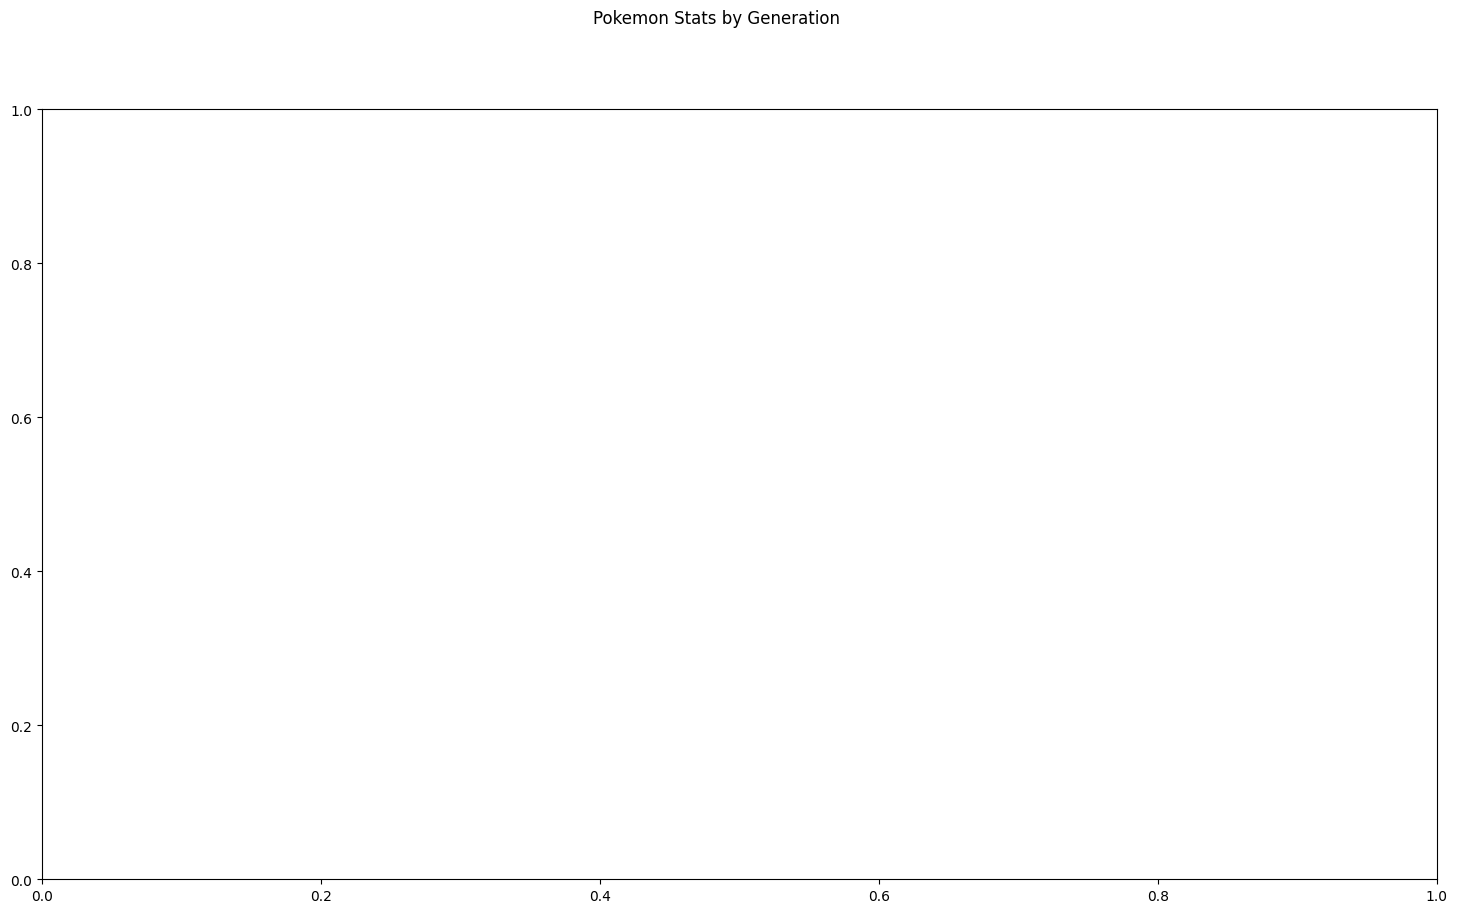

In [103]:
fig, axes = plt.subplots(1, 1, figsize=(18, 10))

fig.suptitle('Pokemon Stats by Generation')

sns.violinplot(ax=axes[0], x="VehBrand", y="ClaimNb", hue="VehGas", data=data, palette="Pastel1")
axes[0].set_ylim(0, 10000)
plt.show()


KeyboardInterrupt



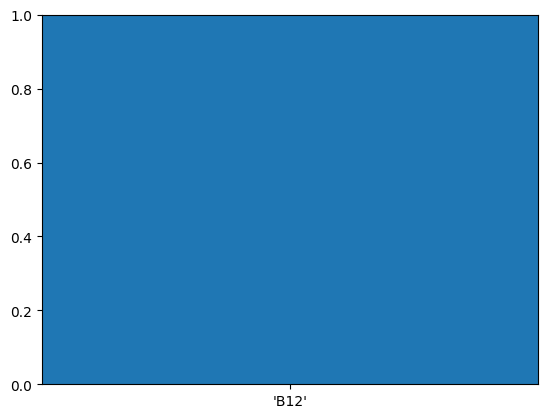

In [75]:
plt.bar(data["VehBrand"], data["ClaimAmount"])

In [ ]:
data = one_hot_encode(data, ["VehBrand", "VehGas", "Region", "Area"])
data = scale_to_max(data, ["VehPower", "DrivAge", "VehAge", "Density"])

data["BonusMalus"]=data["BonusMalus"]/50



In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class ClaimDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = sample[['Exposure',	'Area',	'VehPower',	'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas','Density','Region']].to_numpy()
        target = sample['ClaimNb']
        return torch.tensor(np.concatenate([elem if isinstance(elem, np.ndarray) else np.array([elem]) for elem in features])), torch.tensor(target, dtype=torch.float64)


In [57]:
dataset = df_freq

dataset = one_hot_encode(dataset, ["VehBrand", "VehGas", "Region", "Area"])
dataset = scale_to_max(dataset, ["VehPower", "DrivAge", "VehAge", "Density"])

dataset["BonusMalus"]=dataset["BonusMalus"]/50

dataset = ClaimDataset(dataset)

batch_size = 64


data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

total_batches = 10594


In [58]:
import torch.nn as nn
 
model = nn.Sequential(
    nn.Linear(47, 94),
    nn.ReLU(),
    nn.Linear(94, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

model.double()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





for epoch in range(10):
    for i, batch in enumerate(data_loader):
        x,y = batch
        pred = model(x)
        loss = loss_fn(pred.flatten(), y)
        loss.backward()
        optimizer.step()
    
        if i % 20 == 0:
            
            print("Batch: "+str(i)+"/"+str(total_batches)+" Loss: "+'{:.2e}'.format(loss.item()))

    


Batch: 0/10594 Loss: 5.00e-02
Batch: 20/10594 Loss: 5.16e-02
Batch: 40/10594 Loss: 7.55e-02
Batch: 60/10594 Loss: 9.60e-02
Batch: 80/10594 Loss: 7.77e-02
Batch: 100/10594 Loss: 6.12e-02
Batch: 120/10594 Loss: 9.64e-02
Batch: 140/10594 Loss: 4.71e-02
Batch: 160/10594 Loss: 1.04e-01
Batch: 180/10594 Loss: 5.97e-02
Batch: 200/10594 Loss: 1.54e-02
Batch: 220/10594 Loss: 1.56e-01
Batch: 240/10594 Loss: 4.57e-02
Batch: 260/10594 Loss: 5.88e-02
Batch: 280/10594 Loss: 7.20e-02
Batch: 300/10594 Loss: 4.88e-02
Batch: 320/10594 Loss: 7.41e-02
Batch: 340/10594 Loss: 4.93e-02
Batch: 360/10594 Loss: 3.33e-02
Batch: 380/10594 Loss: 1.33e-01
Batch: 400/10594 Loss: 4.61e-02
Batch: 420/10594 Loss: 8.02e-02
Batch: 440/10594 Loss: 5.08e-02
Batch: 460/10594 Loss: 6.56e-02
Batch: 480/10594 Loss: 4.60e-02
Batch: 500/10594 Loss: 4.47e-02
Batch: 520/10594 Loss: 1.41e-01
Batch: 540/10594 Loss: 7.51e-02
Batch: 560/10594 Loss: 4.57e-02
Batch: 580/10594 Loss: 3.68e-02
Batch: 600/10594 Loss: 5.51e-02
Batch: 620/105

KeyboardInterrupt: 

In [88]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.6 MB/s eta 0:00:006.8 MB/s eta 0:00:01
